In [1]:
import sklearn
import numpy as np
import pandas as pd
import glob
import os

In [2]:
files = glob.glob("C:\\Users\\sidar\\Documents\\Study Materials\\ML4H\\dataset\\dataset\\p*.psv")

In [3]:
dataset = pd.DataFrame()
for file in files:
    df = pd.read_csv(file, delimiter='|')
    df['patient'] = os.path.basename(file)
    dataset = dataset.append(df)

In [24]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1552210 entries, 0 to 34
Data columns (total 42 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   HR                1398811 non-null  float64
 1   O2Sat             1349474 non-null  float64
 2   Temp              525226 non-null   float64
 3   SBP               1325945 non-null  float64
 4   MAP               1358940 non-null  float64
 5   DBP               1065656 non-null  float64
 6   Resp              1313875 non-null  float64
 7   EtCO2             57636 non-null    float64
 8   BaseExcess        84145 non-null    float64
 9   HCO3              65028 non-null    float64
 10  FiO2              129365 non-null   float64
 11  pH                107573 non-null   float64
 12  PaCO2             86301 non-null    float64
 13  SaO2              53561 non-null    float64
 14  AST               25183 non-null    float64
 15  BUN               106568 non-null   float64
 16  Alkal

## Identify Sepsis cohort

In [61]:
sepsis_df = dataset[dataset['ICULOS']<73]

In [84]:
#sepsis_df[sepsis_df['patient']=='p000009.psv']
#dataset[dataset['ICULOS']>72][0:10]

In [73]:
sepsis_posi = sepsis_df[sepsis_df['SepsisLabel']==1]['patient'].unique()

In [74]:
sepsis_trimmed = sepsis_df[sepsis_df['patient'].isin(sepsis_posi)]

In [630]:
#sepsis_trimmed[sepsis_trimmed['patient']=='p000009.psv']
#sepsis_trimmed.info()

In [85]:
filepath = Path('C:\\Users\\sidar\\Desktop\\sepsis_trimmed.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
sepsis_trimmed.to_csv(filepath, index=False)

## Identify AKI cohort

In [5]:
def find_min_creatinine(df, hours, time):
    minimum = 10000000
    
    if hours==48:
        for index in df.index:
            row = df.loc[index]
            if (time - row['ICULOS']) <= 0:
                break
            if ((time - row['ICULOS']) <= 48) & (row['Creatinine'] < minimum):
                minimum = row['Creatinine']
                
    if hours==168:
        for index in df.index:
            row = df.loc[index]
            if (time - row['ICULOS']) <= 0:
                break
            if ((time - row['ICULOS']) <= 168) & (row['Creatinine'] < minimum):
                minimum = row['Creatinine']
    # print(minimum)
    return minimum

In [15]:
aki_df = pd.DataFrame()
for file in glob.glob("C:\\Users\\sidar\\Documents\\Study Materials\\ML4H\\dataset\\dataset\\p*.psv"):
    p_df = pd.read_csv(file, delimiter='|')
    p_df['aki'] = p_df.apply(lambda row: 1 if (row['Creatinine']-find_min_creatinine(p_df,48,row['ICULOS'])>=0.3) or (row['Creatinine']>=(1.5*find_min_creatinine(p_df,168,row['ICULOS']))) else 0, axis=1)
    aki_df = aki_df.append(p_df)

In [19]:
from pathlib import Path  
filepath = Path('C:\\Users\\sidar\\Desktop\\aki_df.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
aki_df.to_csv(filepath, index=False)

In [25]:
aki_df['patient'] = dataset['patient']

In [50]:
#aki_df[aki_df['patient']=='p000009.psv'][27:50]

In [32]:
aki_posi = aki_df[aki_df['aki']==1]['patient'].unique()

In [51]:
#aki_df[aki_df['patient'].isin(['p000001.psv','p000002.psv'])]

In [33]:
aki_posi

array(['p000009.psv', 'p000014.psv', 'p000019.psv', ..., 'p119978.psv',
       'p119989.psv', 'p119998.psv'], dtype=object)

In [87]:
aki_trimmed = pd.DataFrame()
for patient in aki_posi:
    for idx, row in aki_df[aki_df['patient']==patient].iterrows():
        if row['aki']==1:
            break
        aki_trimmed = aki_trimmed.append(row)

In [89]:
#aki_trimmed.info()

In [90]:
filepath = Path('C:\\Users\\sidar\\Desktop\\aki_trimmed.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
aki_trimmed.to_csv(filepath, index=False)

## AKI Feature Stats

In [93]:
cols =['HR','O2Sat','Temp','SBP','MAP','DBP','Resp','EtCO2','BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2','AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate','Magnesium','Phosphate','Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen','Platelets','Age']

### Minimums

In [99]:
aki_features = pd.DataFrame(aki_trimmed[cols].min(), columns={'min'})

### Maximums

In [102]:
aki_features['max'] = pd.DataFrame(aki_trimmed[cols].max())

### Mean

In [103]:
aki_features['mean'] = pd.DataFrame(aki_trimmed[cols].mean())

### Median

In [104]:
aki_features['median'] = pd.DataFrame(aki_trimmed[cols].median())

### Standard Deviation

In [105]:
aki_features['std'] = pd.DataFrame(aki_trimmed[cols].std())

### Missing

In [111]:
aki_features['missing'] = pd.DataFrame(aki_trimmed[cols].isnull().sum())

In [112]:
aki_features.head()

,min,max,mean,median,std,missing
HR,26.0,186.00,85.543562,84.00,17.399620,10567
O2Sat,20.0,100.00,97.296341,98.00,3.131817,14104
Temp,20.9,42.22,36.927364,36.94,0.884694,77346
SBP,20.0,282.00,122.138327,118.50,24.744359,16582
MAP,20.0,298.00,80.692468,78.00,17.288005,12881


In [901]:
aki_features = aki_features.reset_index()

In [900]:
filepath = Path('C:\\Users\\sidar\\Desktop\\aki_features.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
aki_features.to_csv(filepath, index=False)

## Sepsis Feature Stats

### Minimums

In [886]:
sepsis_features = pd.DataFrame(sepsis_trimmed[cols].min(), columns={'min'})

### Maximums

In [887]:
sepsis_features['max'] = pd.DataFrame(sepsis_trimmed[cols].max())

### Mean

In [888]:
sepsis_features['mean'] = pd.DataFrame(sepsis_trimmed[cols].mean())

### Median

In [889]:
sepsis_features['median'] = pd.DataFrame(sepsis_trimmed[cols].median())

### Standard Deviation

In [890]:
sepsis_features['std'] = pd.DataFrame(sepsis_trimmed[cols].std())

### Missing

In [891]:
sepsis_features['missing'] = pd.DataFrame(sepsis_trimmed[cols].isnull().sum())

In [892]:
sepsis_features.head()

,min,max,mean,median,std,missing
HR,26.00,200.0,88.685670,88.00,18.640249,5616
O2Sat,20.00,100.0,97.249582,98.00,3.201345,7060
Temp,26.67,41.3,37.095038,37.11,0.983456,43080
SBP,22.00,280.0,120.691626,118.00,23.515286,11173
MAP,20.00,298.0,79.750424,78.00,16.169131,6690


In [893]:
sepsis_features = sepsis_features.reset_index()

In [895]:
filepath = Path('C:\\Users\\sidar\\Desktop\\sepsis_features.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
sepsis_features.to_csv(filepath, index=False)

## AKI Feature Extraction

In [446]:
min_cols = ['O2Sat','SBP','MAP','DBP','EtCO2','BaseExcess','HCO3','pH','PaCO2','SaO2','Potassium','Hct','Hgb','Fibrinogen','Platelets']
max_cols = ['HR','Temp','Resp','FiO2','AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate','Magnesium','Phosphate','Bilirubin_total','TroponinI','PTT','WBC','Age']

In [447]:
aki_vectors = pd.DataFrame()

In [448]:
for patient in aki_trimmed['patient'].unique():
    df = aki_trimmed[aki_trimmed['patient']==patient]
    aki_vectors_temp = pd.concat([df[min_cols].min(), df[max_cols].max()],axis=0)
    aki_vectors_temp.columns = aki_vectors_temp.iloc[0]
    aki_vectors_temp['patient'] = patient
    aki_vectors = aki_vectors.append(aki_vectors_temp,ignore_index=True)

In [449]:
aki_vectors.info()  ## TRANSPOSE DATAFRAME AND APPEND, CONCATENATING IS OVERWRITING

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4490 entries, 0 to 4489
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   O2Sat             4488 non-null   float64
 1   SBP               4419 non-null   float64
 2   MAP               4481 non-null   float64
 3   DBP               3836 non-null   float64
 4   EtCO2             557 non-null    float64
 5   BaseExcess        2147 non-null   float64
 6   HCO3              2654 non-null   float64
 7   pH                2990 non-null   float64
 8   PaCO2             2945 non-null   float64
 9   SaO2              2253 non-null   float64
 10  Potassium         4453 non-null   float64
 11  Hct               4269 non-null   float64
 12  Hgb               4196 non-null   float64
 13  Fibrinogen        890 non-null    float64
 14  Platelets         4195 non-null   float64
 15  HR                4490 non-null   float64
 16  Temp              4363 non-null   float64


## Sepsis Feature Extraction

In [598]:
sepsis_vectors = pd.DataFrame()
for patient in sepsis_trimmed['patient'].unique():
    series = sepsis_trimmed[sepsis_trimmed['patient']==patient][['Temp']]
    vector = np.array(series[:len(series)])
    i = len(vector)
    while i<72:
        vector = np.append(vector, np.nan)
        i+=1
    vector = pd.DataFrame(vector).T
    vector['patient'] = patient
    sepsis_vectors = sepsis_vectors.append(vector)

In [628]:
sepsis_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,0.769319,0.75000,0.801053,0.807368,0.798958,0.771630,0.767,0.694,0.701719,0.701719,...,0.647573,0.647573,0.647573,0.647573,0.647573,0.647573,0.647573,0.647573,0.647573,0.647573
0,0.550173,0.51250,0.636842,0.652632,0.677083,0.663984,0.670,0.650,0.657230,0.647118,...,0.601942,0.601942,0.601942,0.601942,0.601942,0.601942,0.601942,0.601942,0.601942,0.601942
0,0.634371,0.60375,0.666316,0.684211,0.677083,0.653924,0.650,0.578,0.584429,0.584429,...,0.685437,0.685437,0.685437,0.685437,0.685437,0.685437,0.685437,0.685437,0.685437,0.685437
0,0.551326,0.52125,0.631579,0.631579,0.625000,0.603622,0.600,0.600,0.606673,0.606673,...,0.582524,0.582524,0.582524,0.582524,0.582524,0.582524,0.582524,0.582524,0.582524,0.582524
0,0.564014,0.52750,0.602105,0.602105,0.595833,0.575453,0.617,0.617,0.623862,0.623862,...,0.700971,0.582524,0.582524,0.582524,0.582524,0.582524,0.635922,0.694175,0.733010,0.718447


## AKI Subphenotyping

In [416]:
#aki_vectors.head(10)

In [450]:
aki_vectors.fillna(aki_vectors.median(),inplace=True)

C:\Users\sidar\AppData\Local\Temp/ipykernel_26976/3888492378.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  aki_vectors.fillna(aki_vectors.median(),inplace=True)


In [451]:
aki_vectors.head(10)

,O2Sat,SBP,MAP,DBP,EtCO2,BaseExcess,HCO3,pH,PaCO2,SaO2,...,Glucose,Lactate,Magnesium,Phosphate,Bilirubin_total,TroponinI,PTT,WBC,Age,patient
0,89.5,78.0,56.00,45.0,27.0,-7.0,23.0,7.13,40.0,75.0,...,130.0,3.80,2.3,4.6,0.9,0.29,46.4,12.1,27.92,p000009.psv
1,95.0,77.5,49.00,45.0,27.0,-4.0,20.0,7.30,32.0,62.0,...,187.0,2.40,2.3,4.1,0.9,0.29,48.8,12.1,73.43,p000014.psv
2,88.0,114.0,65.00,47.0,27.0,-9.0,17.0,7.23,41.0,96.0,...,97.0,1.50,1.6,4.1,0.9,0.70,36.5,8.5,46.42,p000019.psv
3,93.0,74.0,57.00,46.0,27.0,-6.0,21.0,7.27,32.0,97.0,...,210.0,4.70,2.1,4.1,0.9,0.29,31.3,14.1,57.13,p000030.psv
4,93.0,69.0,41.00,48.0,27.0,-3.0,21.0,7.33,35.0,94.0,...,224.0,1.80,2.3,6.2,0.9,0.29,48.8,9.8,59.24,p000033.psv
5,91.0,90.0,67.00,54.0,27.0,2.0,29.0,7.31,49.0,92.0,...,151.0,1.10,2.5,4.1,0.9,0.29,40.1,15.0,77.28,p000034.psv
6,97.0,80.0,63.17,48.0,27.0,-3.0,23.0,7.33,35.0,94.0,...,136.0,2.26,1.5,2.2,0.9,0.29,36.5,8.3,57.17,p000040.psv
7,99.5,96.0,68.00,54.0,27.0,-4.0,24.0,7.33,36.0,97.0,...,195.0,1.50,2.3,4.1,0.9,0.29,37.8,11.5,61.34,p000052.psv
8,94.0,96.0,68.00,54.5,27.0,0.0,24.0,7.39,30.0,99.0,...,139.0,2.26,2.1,4.1,0.9,0.29,25.3,11.4,67.57,p000076.psv
9,93.0,84.5,64.00,49.0,27.0,-3.0,24.0,7.37,36.0,98.0,...,160.0,1.00,1.9,3.7,0.9,0.29,37.2,9.9,88.90,p000108.psv


In [452]:
aki_vectors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4490 entries, 0 to 4489
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   O2Sat             4490 non-null   float64
 1   SBP               4490 non-null   float64
 2   MAP               4490 non-null   float64
 3   DBP               4490 non-null   float64
 4   EtCO2             4490 non-null   float64
 5   BaseExcess        4490 non-null   float64
 6   HCO3              4490 non-null   float64
 7   pH                4490 non-null   float64
 8   PaCO2             4490 non-null   float64
 9   SaO2              4490 non-null   float64
 10  Potassium         4490 non-null   float64
 11  Hct               4490 non-null   float64
 12  Hgb               4490 non-null   float64
 13  Fibrinogen        4490 non-null   float64
 14  Platelets         4490 non-null   float64
 15  HR                4490 non-null   float64
 16  Temp              4490 non-null   float64


In [453]:
from scipy import stats

In [458]:
z_scores = pd.DataFrame()
for col in cols:
    
    z = np.abs(stats.zscore(aki_vectors[col]))
    for i in range(len(z)):
        if z[i]>3:
            z_scores.at[i,col] = 1
    
#for j in list_z:
#    aki_vectors.drop(index=j, axis=0, inplace=True)

#for idx in range(len(z)):
    

    #if z[i]>3:
    #    aki_vectors.drop(index=i, axis=0, inplace=True)

In [467]:
#z_scores[60:120]

In [466]:
for idx in z_scores.index:
    aki_vectors.drop(index=idx, axis=0, inplace=True)

In [468]:
aki_vectors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3020 entries, 1 to 4489
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   O2Sat             3020 non-null   float64
 1   SBP               3020 non-null   float64
 2   MAP               3020 non-null   float64
 3   DBP               3020 non-null   float64
 4   EtCO2             3020 non-null   float64
 5   BaseExcess        3020 non-null   float64
 6   HCO3              3020 non-null   float64
 7   pH                3020 non-null   float64
 8   PaCO2             3020 non-null   float64
 9   SaO2              3020 non-null   float64
 10  Potassium         3020 non-null   float64
 11  Hct               3020 non-null   float64
 12  Hgb               3020 non-null   float64
 13  Fibrinogen        3020 non-null   float64
 14  Platelets         3020 non-null   float64
 15  HR                3020 non-null   float64
 16  Temp              3020 non-null   float64


In [469]:
aki_vectors.head()

,O2Sat,SBP,MAP,DBP,EtCO2,BaseExcess,HCO3,pH,PaCO2,SaO2,...,Glucose,Lactate,Magnesium,Phosphate,Bilirubin_total,TroponinI,PTT,WBC,Age,patient
1,95.0,77.5,49.00,45.0,27.0,-4.0,20.0,7.30,32.0,62.0,...,187.0,2.40,2.3,4.1,0.9,0.29,48.8,12.1,73.43,p000014.psv
3,93.0,74.0,57.00,46.0,27.0,-6.0,21.0,7.27,32.0,97.0,...,210.0,4.70,2.1,4.1,0.9,0.29,31.3,14.1,57.13,p000030.psv
4,93.0,69.0,41.00,48.0,27.0,-3.0,21.0,7.33,35.0,94.0,...,224.0,1.80,2.3,6.2,0.9,0.29,48.8,9.8,59.24,p000033.psv
6,97.0,80.0,63.17,48.0,27.0,-3.0,23.0,7.33,35.0,94.0,...,136.0,2.26,1.5,2.2,0.9,0.29,36.5,8.3,57.17,p000040.psv
7,99.5,96.0,68.00,54.0,27.0,-4.0,24.0,7.33,36.0,97.0,...,195.0,1.50,2.3,4.1,0.9,0.29,37.8,11.5,61.34,p000052.psv


In [296]:
temp = aki_vectors

In [470]:
def minmax_scaling(col):
    return (col - col.min()) / (col.max() - col.min())

In [471]:
for col in cols:
    aki_vectors[col] = minmax_scaling(aki_vectors[col])

In [472]:
aki_vectors.head()

,O2Sat,SBP,MAP,DBP,EtCO2,BaseExcess,HCO3,pH,PaCO2,SaO2,...,Glucose,Lactate,Magnesium,Phosphate,Bilirubin_total,TroponinI,PTT,WBC,Age,patient
1,0.827586,0.320574,0.302632,0.431034,0.5,0.473684,0.40,0.454545,0.394737,0.155556,...,0.398964,0.227273,0.518519,0.4375,0.070796,0.006272,0.291871,0.345821,0.668207,p000014.psv
3,0.758621,0.287081,0.407895,0.448276,0.5,0.368421,0.45,0.386364,0.394737,0.933333,...,0.458549,0.488636,0.444444,0.4375,0.070796,0.006272,0.120470,0.403458,0.464660,p000030.psv
4,0.758621,0.239234,0.197368,0.482759,0.5,0.526316,0.45,0.522727,0.473684,0.866667,...,0.494819,0.159091,0.518519,0.7000,0.070796,0.006272,0.291871,0.279539,0.491009,p000033.psv
6,0.896552,0.344498,0.489079,0.482759,0.5,0.526316,0.55,0.522727,0.473684,0.866667,...,0.266839,0.211364,0.222222,0.2000,0.070796,0.006272,0.171401,0.236311,0.465160,p000040.psv
7,0.982759,0.497608,0.552632,0.586207,0.5,0.473684,0.60,0.522727,0.500000,0.933333,...,0.419689,0.125000,0.518519,0.4375,0.070796,0.006272,0.184133,0.328530,0.517233,p000052.psv


In [473]:
pt_col_aki = aki_vectors['patient']

In [474]:
aki_vectors = aki_vectors[cols]

In [475]:
aki_vectors.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age
1,0.398230,0.827586,0.663158,0.320574,0.302632,0.431034,0.428571,0.5,0.473684,0.40,...,0.425,0.070796,0.006272,0.344118,0.380531,0.291871,0.345821,0.471354,0.235955,0.668207
3,0.389381,0.758621,0.423158,0.287081,0.407895,0.448276,0.404762,0.5,0.368421,0.45,...,0.375,0.070796,0.006272,0.391176,0.433628,0.120470,0.403458,0.471354,0.242697,0.464660
4,0.530973,0.758621,0.456842,0.239234,0.197368,0.482759,0.333333,0.5,0.526316,0.45,...,0.550,0.070796,0.006272,0.461765,0.424779,0.291871,0.279539,0.471354,0.456180,0.491009
6,0.513274,0.896552,0.433684,0.344498,0.489079,0.482759,0.547619,0.5,0.526316,0.55,...,1.000,0.070796,0.006272,0.511765,0.460177,0.171401,0.236311,0.471354,0.692135,0.465160
7,0.380531,0.982759,0.368421,0.497608,0.552632,0.586207,0.273810,0.5,0.473684,0.60,...,0.550,0.070796,0.006272,0.426471,0.424779,0.184133,0.328530,0.471354,0.449438,0.517233


In [476]:
filepath = Path('C:\\Users\\sidar\\Desktop\\aki_vectors_data.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
aki_vectors.to_csv(filepath, index=False)

## Sepsis Subphenotyping

In [600]:
pt_col_sepsis = sepsis_vectors['patient']
sepsis_vectors = sepsis_vectors.drop(['patient'], axis=1).fillna(method = 'bfill', axis = 1)
sepsis_vectors = sepsis_vectors.fillna(method = 'ffill', axis = 1)
sepsis_vectors['patient'] = pt_col_sepsis

In [603]:
sepsis_vectors = sepsis_vectors.dropna(how = 'any')

In [604]:
sepsis_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,patient
0,38.00,38.00,38.11,38.17,38.17,38.17,38.17,37.44,37.44,37.44,...,37.17,37.17,37.17,37.17,37.17,37.17,37.17,37.17,37.17,p000011.psv
0,36.10,36.10,36.55,36.70,37.00,37.10,37.20,37.00,37.00,36.90,...,36.70,36.70,36.70,36.70,36.70,36.70,36.70,36.70,36.70,p000015.psv
0,36.83,36.83,36.83,37.00,37.00,37.00,37.00,36.28,36.28,36.28,...,37.56,37.56,37.56,37.56,37.56,37.56,37.56,37.56,37.56,p000028.psv
0,36.11,36.17,36.50,36.50,36.50,36.50,36.50,36.50,36.50,36.50,...,36.50,36.50,36.50,36.50,36.50,36.50,36.50,36.50,36.50,p000034.psv
0,36.22,36.22,36.22,36.22,36.22,36.22,36.67,36.67,36.67,36.67,...,36.50,36.50,36.50,36.50,36.50,37.05,37.65,38.05,37.90,p000042.psv


In [609]:
sepsis_temp = sepsis_vectors.drop(['patient'], axis=1)
for col in sepsis_temp.columns:
    sepsis_vectors[col] = minmax_scaling(sepsis_vectors[col])

In [773]:
sepsis_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,clusters
0,0.769319,0.75000,0.801053,0.807368,0.798958,0.771630,0.767,0.694,0.701719,0.701719,...,0.647573,0.647573,0.647573,0.647573,0.647573,0.647573,0.647573,0.647573,0.647573,1.0
0,0.550173,0.51250,0.636842,0.652632,0.677083,0.663984,0.670,0.650,0.657230,0.647118,...,0.601942,0.601942,0.601942,0.601942,0.601942,0.601942,0.601942,0.601942,0.601942,1.0
0,0.634371,0.60375,0.666316,0.684211,0.677083,0.653924,0.650,0.578,0.584429,0.584429,...,0.685437,0.685437,0.685437,0.685437,0.685437,0.685437,0.685437,0.685437,0.685437,1.0
0,0.551326,0.52125,0.631579,0.631579,0.625000,0.603622,0.600,0.600,0.606673,0.606673,...,0.582524,0.582524,0.582524,0.582524,0.582524,0.582524,0.582524,0.582524,0.582524,1.0
0,0.564014,0.52750,0.602105,0.602105,0.595833,0.575453,0.617,0.617,0.623862,0.623862,...,0.582524,0.582524,0.582524,0.582524,0.582524,0.635922,0.694175,0.733010,0.718447,1.0


In [611]:
pt_col_sepsis = sepsis_vectors['patient']
sepsis_vectors = sepsis_vectors.drop(['patient'], axis=1)

In [625]:
filepath = Path('C:\\Users\\sidar\\Desktop\\sepsis_vectors_data.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
sepsis_vectors.to_csv(filepath, index=False)

In [626]:
sepsis_vectors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2154 entries, 0 to 0
Data columns (total 72 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       2154 non-null   float64
 1   1       2154 non-null   float64
 2   2       2154 non-null   float64
 3   3       2154 non-null   float64
 4   4       2154 non-null   float64
 5   5       2154 non-null   float64
 6   6       2154 non-null   float64
 7   7       2154 non-null   float64
 8   8       2154 non-null   float64
 9   9       2154 non-null   float64
 10  10      2154 non-null   float64
 11  11      2154 non-null   float64
 12  12      2154 non-null   float64
 13  13      2154 non-null   float64
 14  14      2154 non-null   float64
 15  15      2154 non-null   float64
 16  16      2154 non-null   float64
 17  17      2154 non-null   float64
 18  18      2154 non-null   float64
 19  19      2154 non-null   float64
 20  20      2154 non-null   float64
 21  21      2154 non-null   float64
 22  22 

## AKI K-Means

In [477]:
from sklearn.cluster import KMeans

In [478]:
kmeans = KMeans(init="k-means++", n_clusters=2, random_state=43)

In [479]:
labels = kmeans.fit_predict(aki_vectors)

In [480]:
type(pt_col_aki)

pandas.core.series.Series

In [481]:
len(pt_col_aki)

3020

In [482]:
aki_clusters = pd.DataFrame()
aki_clusters['id'] = pt_col_aki
aki_clusters['labels'] = labels

In [483]:
aki_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3020 entries, 1 to 4489
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3020 non-null   object
 1   labels  3020 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 59.0+ KB


In [484]:
aki_clusters.head()

,id,labels
1,p000014.psv,0
3,p000030.psv,1
4,p000033.psv,1
6,p000040.psv,1
7,p000052.psv,1


In [497]:
for idx, row in aki_clusters.iterrows():
    if row['labels']==0:
        aki_clusters.at[idx,'cluster_0'] = 1
        aki_clusters.at[idx,'cluster_1'] = 0
    else:
        aki_clusters.at[idx,'cluster_0'] = 0
        aki_clusters.at[idx,'cluster_1'] = 1

In [502]:
aki_clusters_final = aki_clusters.drop('labels',axis=1)

In [503]:
aki_clusters_final.head(10)

,id,cluster_0,cluster_1
1,p000014.psv,1.0,0.0
3,p000030.psv,0.0,1.0
4,p000033.psv,0.0,1.0
6,p000040.psv,0.0,1.0
7,p000052.psv,0.0,1.0
8,p000076.psv,0.0,1.0
9,p000108.psv,0.0,1.0
10,p000119.psv,0.0,1.0
11,p000125.psv,0.0,1.0
12,p000130.psv,1.0,0.0


In [504]:
aki_clusters_final['cluster_0'].sum()

508.0

In [506]:
aki_clusters_final['cluster_1'].sum()

2512.0

In [505]:
filepath = Path('C:\\Users\\sidar\\Desktop\\aki_clusters.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
aki_clusters_final.to_csv(filepath, index=False)

## Sepsis Agglomerative Clustering

In [632]:
'''
Used Colab to compute DTW score matrix since tslearn didn't work locally. Code as follows.

import numpy as np
import pandas as pd

#!pip install tslearn
from tslearn.metrics import cdist_dtw

sepsis_vectors_data = pd.read_csv('sepsis_vectors_data.csv')

matrix = cdist_dtw(sepsis_vectors_data)

matrix = pd.DataFrame(matrix)

from google.colab import drive
drive.mount('drive')

matrix.to_csv('matrix.csv', index=False)
'''

"\nUsed Colab to compute DTW score matrix since tslearn didn't work locally. Code as follows.\n\nimport numpy as np\nimport pandas as pd\n\n#!pip install tslearn\nfrom tslearn.metrics import cdist_dtw\n\nsepsis_vectors_data = pd.read_csv('sepsis_vectors_data.csv')\n\nmatrix = cdist_dtw(sepsis_vectors_data)\n\nmatrix = pd.DataFrame(matrix)\n\nfrom google.colab import drive\ndrive.mount('drive')\n\nmatrix.to_csv('matrix.csv', index=False)\n"

In [657]:
matrix = pd.read_csv("C:\\Users\\sidar\\Desktop\\matrix.csv")

In [658]:
matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,2144,2145,2146,2147,2148,2149,2150,2151,2152,2153
0,0.000000,0.570267,0.417599,0.677148,0.703409,0.462280,0.489521,1.862397,1.302803,0.175778,...,0.608732,0.492035,0.315221,0.667005,0.474653,1.305980,0.762075,0.560822,0.618516,0.742305
1,0.570267,0.000000,0.449169,0.167281,0.508013,0.893044,0.150089,0.945689,1.402338,0.511061,...,0.119285,0.583443,0.429721,0.224080,0.166018,0.568729,0.294014,0.523638,0.327247,0.185870
2,0.417599,0.449169,0.000000,0.537631,0.425282,0.449322,0.383492,1.652847,1.056736,0.285716,...,0.444049,0.331880,0.324356,0.567489,0.376990,1.119516,0.621070,0.412865,0.658710,0.480722
3,0.677148,0.167281,0.537631,0.000000,0.539097,1.091058,0.280042,0.870079,1.495438,0.645737,...,0.159396,0.687887,0.491893,0.111756,0.294405,0.534196,0.163475,0.636414,0.284499,0.333225
4,0.703409,0.508013,0.425282,0.539097,0.000000,0.733873,0.479775,1.300200,1.013835,0.648188,...,0.513626,0.552720,0.448150,0.560742,0.495817,0.885076,0.586892,0.465657,0.624083,0.406612


In [659]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154 entries, 0 to 2153
Columns: 2154 entries, 0 to 2153
dtypes: float64(2154)
memory usage: 35.4 MB


In [719]:
from sklearn.cluster import AgglomerativeClustering as AC

ac = AC(linkage = 'complete', affinity = 'precomputed', n_clusters=2)

In [720]:
clustering = ac.fit_predict(matrix)

In [721]:
sepsis_clusters = pd.DataFrame()
sepsis_clusters['id'] = pt_col_sepsis
sepsis_clusters['cluster'] = clustering

In [722]:
sepsis_clusters[sepsis_clusters['cluster']==1].count()

id         2038
cluster    2038
dtype: int64

In [723]:
sepsis_clusters = sepsis_clusters.reset_index(drop=True)
sepsis_clusters.head(8)

,id,cluster
0,p000011.psv,1
1,p000015.psv,1
2,p000028.psv,1
3,p000034.psv,1
4,p000042.psv,1
5,p000053.psv,1
6,p000056.psv,1
7,p000058.psv,0


In [724]:
for idx, row in sepsis_clusters.iterrows():
    if row['cluster']==0:
        sepsis_clusters.at[idx,'cluster_0'] = 1
        sepsis_clusters.at[idx,'cluster_1'] = 0
    else:
        sepsis_clusters.at[idx,'cluster_0'] = 0
        sepsis_clusters.at[idx,'cluster_1'] = 1

In [725]:
sepsis_clusters_final = sepsis_clusters.drop('cluster',axis=1)

In [730]:
sepsis_clusters_final.head(8)

,id,cluster_0,cluster_1
0,p000011.psv,0.0,1.0
1,p000015.psv,0.0,1.0
2,p000028.psv,0.0,1.0
3,p000034.psv,0.0,1.0
4,p000042.psv,0.0,1.0
5,p000053.psv,0.0,1.0
6,p000056.psv,0.0,1.0
7,p000058.psv,1.0,0.0


In [727]:
sepsis_clusters_final['cluster_0'].sum()

116.0

In [728]:
sepsis_clusters_final['cluster_1'].sum()

2038.0

In [729]:
filepath = Path('C:\\Users\\sidar\\Desktop\\sepsis_clusters.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
sepsis_clusters_final.to_csv(filepath, index=False)

## AKI Cluster Stats

In [515]:
aki_vectors['cluster_0'] = aki_clusters_final['cluster_0']
aki_vectors['cluster_1'] = aki_clusters_final['cluster_1']

C:\Users\sidar\AppData\Local\Temp/ipykernel_26976/2541093362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aki_vectors['cluster_0'] = aki_clusters_final['cluster_0']
C:\Users\sidar\AppData\Local\Temp/ipykernel_26976/2541093362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aki_vectors['cluster_1'] = aki_clusters_final['cluster_1']


In [516]:
aki_vectors.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,cluster_0,cluster_1
1,0.398230,0.827586,0.663158,0.320574,0.302632,0.431034,0.428571,0.5,0.473684,0.40,...,0.006272,0.344118,0.380531,0.291871,0.345821,0.471354,0.235955,0.668207,1.0,0.0
3,0.389381,0.758621,0.423158,0.287081,0.407895,0.448276,0.404762,0.5,0.368421,0.45,...,0.006272,0.391176,0.433628,0.120470,0.403458,0.471354,0.242697,0.464660,0.0,1.0
4,0.530973,0.758621,0.456842,0.239234,0.197368,0.482759,0.333333,0.5,0.526316,0.45,...,0.006272,0.461765,0.424779,0.291871,0.279539,0.471354,0.456180,0.491009,0.0,1.0
6,0.513274,0.896552,0.433684,0.344498,0.489079,0.482759,0.547619,0.5,0.526316,0.55,...,0.006272,0.511765,0.460177,0.171401,0.236311,0.471354,0.692135,0.465160,0.0,1.0
7,0.380531,0.982759,0.368421,0.497608,0.552632,0.586207,0.273810,0.5,0.473684,0.60,...,0.006272,0.426471,0.424779,0.184133,0.328530,0.471354,0.449438,0.517233,0.0,1.0


In [517]:
aki_cluster_0 = aki_vectors[aki_vectors['cluster_0']==1]
aki_cluster_1 = aki_vectors[aki_vectors['cluster_1']==1]

In [518]:
aki_cluster_0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508 entries, 1 to 4445
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HR                508 non-null    float64
 1   O2Sat             508 non-null    float64
 2   Temp              508 non-null    float64
 3   SBP               508 non-null    float64
 4   MAP               508 non-null    float64
 5   DBP               508 non-null    float64
 6   Resp              508 non-null    float64
 7   EtCO2             508 non-null    float64
 8   BaseExcess        508 non-null    float64
 9   HCO3              508 non-null    float64
 10  FiO2              508 non-null    float64
 11  pH                508 non-null    float64
 12  PaCO2             508 non-null    float64
 13  SaO2              508 non-null    float64
 14  AST               508 non-null    float64
 15  BUN               508 non-null    float64
 16  Alkalinephos      508 non-null    float64
 

In [519]:
aki_cluster_features = pd.DataFrame(aki_cluster_0[cols].mean(), columns={'cluster_0_mean'})

In [520]:
aki_cluster_features['cluster_0_std'] = pd.DataFrame(aki_cluster_0[cols].std())

In [521]:
aki_cluster_features['cluster_1_mean'] = pd.DataFrame(aki_cluster_1[cols].mean())

In [522]:
aki_cluster_features['cluster_1_std'] = pd.DataFrame(aki_cluster_1[cols].std())

In [523]:
aki_cluster_features.head()

,cluster_0_mean,cluster_0_std,cluster_1_mean,cluster_1_std
HR,0.453636,0.126350,0.473133,0.167684
O2Sat,0.777865,0.130352,0.764091,0.150095
Temp,0.547816,0.136103,0.499009,0.152494
SBP,0.438046,0.092894,0.502768,0.155843
MAP,0.422290,0.107913,0.496059,0.154482


In [896]:
aki_cluster_features = aki_cluster_features.reset_index()

In [914]:
from scipy.stats import kruskal

pvalues = []
for col in cols:
    statistic, pvalue = kruskal(aki_cluster_0[col], aki_cluster_1[col])
    pvalues.append(pvalue)

In [915]:
pvalues

[0.009972758986910163,
 0.15566930142355104,
 1.4208573344424296e-14,
 5.543016200508539e-19,
 4.8309811999688364e-27,
 1.0927389057414245e-25,
 0.39382302017760706,
 0.4912438080541225,
 1.323696734716331e-09,
 0.9779330199556243,
 1.2348482044707107e-42,
 5.663394039133922e-16,
 8.106027018344334e-08,
 0.0,
 2.889183819654158e-06,
 4.611117226457798e-12,
 1.74481215316307e-05,
 0.7313080721395365,
 4.7103896366919634e-42,
 5.900092125569176e-27,
 0.1153851704949336,
 9.524949578228884e-05,
 3.412216114508942e-05,
 1.8549514500076834e-24,
 0.05185115590773324,
 0.001473464077731061,
 0.9544677527077695,
 0.05248091694441687,
 3.9203461913566223e-23,
 3.1580015081853746e-09,
 1.026004949503092e-34,
 2.5833433365053714e-19,
 0.713978487683013,
 2.941684885592713e-15,
 1.1520407110756863e-20]

In [916]:
aki_cluster_features['pvalue'] = pvalues

In [917]:
filepath = Path('C:\\Users\\sidar\\Desktop\\aki_cluster_features.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
aki_cluster_features.to_csv(filepath, index=False)

HR, Temp, SBP, MAP, DBP, BaseExcess, FiO2, pH, PaCO2, SaO2, AST, BUN, Alkalinephos, Chloride, Creatinine, Glucose, Lactate, Magnesium, Potassium, Hct, Hgb, PTT, WBC, Platelets, Age show significant differences (p<0.05)

## Sepsis Clustering Analysis

In [742]:
sepsis_cluster_temps = sepsis_vectors
sepsis_cluster_temps.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,clusters
0,0.769319,0.75000,0.801053,0.807368,0.798958,0.771630,0.767,0.694,0.701719,0.701719,...,0.647573,0.647573,0.647573,0.647573,0.647573,0.647573,0.647573,0.647573,0.647573,1.0
0,0.550173,0.51250,0.636842,0.652632,0.677083,0.663984,0.670,0.650,0.657230,0.647118,...,0.601942,0.601942,0.601942,0.601942,0.601942,0.601942,0.601942,0.601942,0.601942,1.0
0,0.634371,0.60375,0.666316,0.684211,0.677083,0.653924,0.650,0.578,0.584429,0.584429,...,0.685437,0.685437,0.685437,0.685437,0.685437,0.685437,0.685437,0.685437,0.685437,1.0
0,0.551326,0.52125,0.631579,0.631579,0.625000,0.603622,0.600,0.600,0.606673,0.606673,...,0.582524,0.582524,0.582524,0.582524,0.582524,0.582524,0.582524,0.582524,0.582524,1.0
0,0.564014,0.52750,0.602105,0.602105,0.595833,0.575453,0.617,0.617,0.623862,0.623862,...,0.582524,0.582524,0.582524,0.582524,0.582524,0.635922,0.694175,0.733010,0.718447,1.0


In [745]:
sepsis_cluster_temps = sepsis_cluster_temps.reset_index(drop=True)

In [746]:
sepsis_cluster_temps['clusters'] = sepsis_clusters_final['cluster_1'] 

In [747]:
sepsis_cluster_temps.head(9)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,clusters
0,0.769319,0.75000,0.801053,0.807368,0.798958,0.771630,0.767,0.694,0.701719,0.701719,...,0.647573,0.647573,0.647573,0.647573,0.647573,0.647573,0.647573,0.647573,0.647573,1.0
1,0.550173,0.51250,0.636842,0.652632,0.677083,0.663984,0.670,0.650,0.657230,0.647118,...,0.601942,0.601942,0.601942,0.601942,0.601942,0.601942,0.601942,0.601942,0.601942,1.0
2,0.634371,0.60375,0.666316,0.684211,0.677083,0.653924,0.650,0.578,0.584429,0.584429,...,0.685437,0.685437,0.685437,0.685437,0.685437,0.685437,0.685437,0.685437,0.685437,1.0
3,0.551326,0.52125,0.631579,0.631579,0.625000,0.603622,0.600,0.600,0.606673,0.606673,...,0.582524,0.582524,0.582524,0.582524,0.582524,0.582524,0.582524,0.582524,0.582524,1.0
4,0.564014,0.52750,0.602105,0.602105,0.595833,0.575453,0.617,0.617,0.623862,0.623862,...,0.582524,0.582524,0.582524,0.582524,0.582524,0.635922,0.694175,0.733010,0.718447,1.0
5,0.769319,0.70125,0.748421,0.748421,0.804167,0.776660,0.772,0.733,0.741153,0.741153,...,0.728155,0.728155,0.728155,0.728155,0.728155,0.728155,0.728155,0.728155,0.728155,1.0
6,0.583622,0.54875,0.672632,0.637895,0.665625,0.642857,0.639,0.639,0.646107,0.646107,...,0.620388,0.620388,0.620388,0.620388,0.620388,0.620388,0.620388,0.620388,0.620388,1.0
7,0.461361,0.41625,0.473684,0.473684,0.468750,0.452716,0.450,0.450,0.455005,0.455005,...,0.436893,0.436893,0.436893,0.436893,0.436893,0.436893,0.436893,0.436893,0.436893,0.0
8,0.570934,0.53500,0.578947,0.578947,0.572917,0.559356,0.550,0.539,0.859454,0.859454,...,0.825243,0.825243,0.825243,0.825243,0.825243,0.825243,0.825243,0.825243,0.825243,1.0


In [754]:
sepsis_c0 = sepsis_cluster_temps[sepsis_cluster_temps['clusters']==0]
sepsis_c0.drop(['clusters'], axis=1, inplace=True)
sepsis_c1 = sepsis_cluster_temps[sepsis_cluster_temps['clusters']==1]
sepsis_c1.drop(['clusters'], axis=1, inplace=True)

C:\Users\sidar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [755]:
sepsis_c0.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
7,0.461361,0.41625,0.473684,0.473684,0.468750,0.452716,0.450,0.450,0.455005,0.455005,...,0.436893,0.436893,0.436893,0.436893,0.436893,0.436893,0.436893,0.436893,0.436893,0.436893
16,0.603230,0.57000,0.637895,0.637895,0.631250,0.609658,0.606,0.606,0.488372,0.488372,...,0.388350,0.388350,0.388350,0.388350,0.388350,0.388350,0.388350,0.388350,0.388350,0.388350
20,0.442907,0.39625,0.549474,0.549474,0.439583,0.424547,0.422,0.422,0.448938,0.461072,...,0.485437,0.485437,0.485437,0.485437,0.485437,0.485437,0.485437,0.485437,0.485437,0.485437
73,0.358708,0.30500,0.414737,0.414737,0.410417,0.396378,0.394,0.394,0.398382,0.398382,...,0.382524,0.382524,0.382524,0.382524,0.382524,0.382524,0.382524,0.382524,0.382524,0.382524
77,0.513264,0.47250,0.555789,0.555789,0.532292,0.514085,0.511,0.511,0.516684,0.516684,...,0.496117,0.496117,0.496117,0.496117,0.496117,0.496117,0.496117,0.496117,0.496117,0.496117


In [756]:
import matplotlib.pyplot as plt

%matplotlib inline

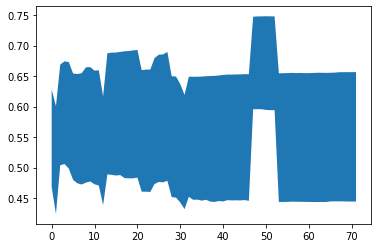

In [771]:
x = sepsis_c0.columns
x = np.array(x).tolist()
plt.fill_between(x = x, y1 = sepsis_c0[:].mean(), y2 = sepsis_c1[:].mean())

## Sepsis Clustering Stats

In [789]:
cols_templess =['HR','O2Sat','SBP','MAP','DBP','Resp','EtCO2','BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2','AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate','Magnesium','Phosphate','Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen','Platelets','Age']

for patient in sepsis_trimmed['patient'].unique():
    df = sepsis_trimmed[sepsis_trimmed['patient']==patient]
    sepsis_vectors_temp = df[cols_templess].mean()
    sepsis_vectors_temp.columns = cols_templess
    sepsis_vectors_temp['patient'] = patient
    sepsis_vectors = sepsis_vectors.append(sepsis_vectors_temp, ignore_index = True)
    
    
    #df = aki_trimmed[aki_trimmed['patient']==patient]
    #aki_vectors_temp = pd.concat([df[min_cols].min(), df[max_cols].max()],axis=0)
    #aki_vectors_temp.columns = aki_vectors_temp.iloc[0]
    #aki_vectors_temp['patient'] = patient
    #aki_vectors = aki_vectors.append(aki_vectors_temp,ignore_index=True)

In [791]:
sepsis_vectors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2188 entries, 0 to 2187
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HR                2188 non-null   float64
 1   O2Sat             2186 non-null   float64
 2   SBP               2082 non-null   float64
 3   MAP               2188 non-null   float64
 4   DBP               1741 non-null   float64
 5   Resp              2176 non-null   float64
 6   EtCO2             345 non-null    float64
 7   BaseExcess        1088 non-null   float64
 8   HCO3              1262 non-null   float64
 9   FiO2              1525 non-null   float64
 10  pH                1548 non-null   float64
 11  PaCO2             1525 non-null   float64
 12  SaO2              995 non-null    float64
 13  AST               1110 non-null   float64
 14  BUN               1997 non-null   float64
 15  Alkalinephos      1103 non-null   float64
 16  Calcium           1928 non-null   float64


In [794]:
sepsis_vectors_trimmed = pd.DataFrame()
for iden in sepsis_clusters_final['id']:
    sepsis_vectors_trimmed = sepsis_vectors_trimmed.append(sepsis_vectors[sepsis_vectors['patient']==iden])

In [798]:
sepsis_vectors_trimmed['cluster'] = sepsis_clusters_final['cluster_1']

In [801]:
sepsis_vectors_trimmed.head()

,HR,O2Sat,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,...,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,patient,cluster
0,89.121212,100.000000,140.703125,88.218750,62.750000,16.370370,NaN,0.500000,23.625000,0.425000,...,NaN,34.625000,12.200000,25.600000,11.233333,NaN,198.000000,65.79,p000011.psv,1.0
1,87.769231,NaN,117.615385,88.935385,72.346154,10.833333,NaN,-8.000000,17.500000,0.400000,...,NaN,31.300000,10.466667,48.233333,15.150000,NaN,114.500000,58.54,p000015.psv,1.0
3,92.833333,96.900000,125.111111,87.716667,73.944444,27.741379,NaN,-4.666667,19.666667,0.668182,...,NaN,28.675000,9.275000,26.100000,8.325000,549.0,96.250000,56.46,p000028.psv,1.0
4,84.346154,93.307692,102.423077,74.692308,57.961538,20.923077,NaN,2.833333,29.000000,0.666667,...,NaN,27.533333,8.500000,40.100000,15.000000,NaN,472.000000,77.28,p000034.psv,1.0
5,103.041667,96.916667,117.872727,80.709091,60.795455,16.934426,NaN,1.250000,24.200000,0.500000,...,NaN,29.835714,9.914286,28.540000,10.100000,652.0,368.833333,63.59,p000042.psv,1.0


In [803]:
sepsis_vectors_trimmed.fillna(aki_vectors.median(),inplace=True)

In [804]:
sepsis_vectors_trimmed.head()

,HR,O2Sat,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,...,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,patient,cluster
0,89.121212,100.000000,140.703125,88.218750,62.750000,16.370370,0.5,0.500000,23.625000,0.425000,...,0.006272,34.625000,12.200000,25.600000,11.233333,0.471354,198.000000,65.79,p000011.psv,1.0
1,87.769231,0.793103,117.615385,88.935385,72.346154,10.833333,0.5,-8.000000,17.500000,0.400000,...,0.006272,31.300000,10.466667,48.233333,15.150000,0.471354,114.500000,58.54,p000015.psv,1.0
3,92.833333,96.900000,125.111111,87.716667,73.944444,27.741379,0.5,-4.666667,19.666667,0.668182,...,0.006272,28.675000,9.275000,26.100000,8.325000,549.000000,96.250000,56.46,p000028.psv,1.0
4,84.346154,93.307692,102.423077,74.692308,57.961538,20.923077,0.5,2.833333,29.000000,0.666667,...,0.006272,27.533333,8.500000,40.100000,15.000000,0.471354,472.000000,77.28,p000034.psv,1.0
5,103.041667,96.916667,117.872727,80.709091,60.795455,16.934426,0.5,1.250000,24.200000,0.500000,...,0.006272,29.835714,9.914286,28.540000,10.100000,652.000000,368.833333,63.59,p000042.psv,1.0


In [867]:
sepsis_vectors_c0 = sepsis_vectors_trimmed[sepsis_vectors_trimmed['cluster']==0]
sepsis_vectors_c1 = sepsis_vectors_trimmed[sepsis_vectors_trimmed['cluster']==1]

In [868]:
sepsis_vectors_c0.head()

,HR,O2Sat,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,...,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,patient,cluster
7,89.000,96.187500,134.375000,84.625000,62.875000,15.937500,0.5,0.526316,21.000000,0.500000,...,0.006272,21.100000,7.400000,22.500000,15.400000,0.471354,167.000000,68.20,p000056.psv,0.0
16,96.500,93.000000,114.062500,68.428571,0.482759,26.812500,0.5,0.526316,0.500000,0.111748,...,0.006272,0.464706,0.477876,0.171401,0.325648,0.471354,0.337079,70.50,p000211.psv,0.0
20,97.500,99.776316,119.932432,74.337500,57.324324,17.612500,0.5,2.722222,25.333333,0.433333,...,0.006272,23.780769,8.700000,29.650000,12.466667,0.471354,156.666667,42.95,p000283.psv,0.0
73,75.625,98.500000,121.171875,78.968750,60.484375,19.843750,0.5,-2.750000,23.000000,0.840000,...,0.006272,27.400000,9.500000,34.500000,7.633333,0.471354,80.666667,74.81,p001128.psv,0.0
77,88.250,97.125000,150.583333,91.041667,80.000000,26.604167,0.5,-4.000000,23.500000,0.750000,...,0.006272,45.200000,15.800000,0.171401,11.800000,0.471354,165.000000,77.61,p001194.psv,0.0


In [869]:
sepsis_mean0 = sepsis_vectors_c0.mean()
sepsis_mean1 = sepsis_vectors_c1.mean()

C:\Users\sidar\AppData\Local\Temp/ipykernel_26976/2672377394.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sepsis_mean0 = sepsis_vectors_c0.mean()
C:\Users\sidar\AppData\Local\Temp/ipykernel_26976/2672377394.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sepsis_mean1 = sepsis_vectors_c1.mean()


In [870]:
sepsis_mean0.drop(['cluster'], inplace=True)
sepsis_mean1.drop(['cluster'], inplace=True)

In [871]:
sepsis_std0 = sepsis_vectors_c0.std()
sepsis_std1 = sepsis_vectors_c1.std()

C:\Users\sidar\AppData\Local\Temp/ipykernel_26976/1422637265.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sepsis_std0 = sepsis_vectors_c0.std()
C:\Users\sidar\AppData\Local\Temp/ipykernel_26976/1422637265.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sepsis_std1 = sepsis_vectors_c1.std()


In [872]:
sepsis_std0.drop(['cluster'], inplace=True)
sepsis_std1.drop(['cluster'], inplace=True)

In [875]:
sepsis_stats = pd.DataFrame()
sepsis_stats['cluster_0_mean'] = sepsis_mean0
sepsis_stats['cluster_1_mean'] = sepsis_mean1
sepsis_stats['cluster_0_std'] = sepsis_std0
sepsis_stats['cluster_1_std'] = sepsis_std1

In [876]:
sepsis_stats

,cluster_0_mean,cluster_1_mean,cluster_0_std,cluster_1_std
HR,88.759893,89.612315,16.063836,16.670604
O2Sat,97.418624,97.118125,1.962799,3.812105
SBP,115.160472,113.801267,33.075251,31.422383
MAP,80.446956,79.586131,13.280927,12.313886
DBP,49.481261,49.157249,27.050300,27.014023
Resp,19.477389,19.578114,4.727819,4.922253
EtCO2,6.193390,5.346295,12.434330,11.693633
BaseExcess,-0.091725,-0.053620,3.130380,3.136460
HCO3,13.503054,13.999909,11.833984,11.905543
FiO2,0.432843,0.432723,0.267852,0.263449


In [880]:
sepsis_stats = sepsis_stats.reset_index()

In [909]:
pvalues = []
for col in cols_templess:
    statistic, pvalue = kruskal(sepsis_vectors_c0[col], sepsis_vectors_c1[col])
    pvalues.append(pvalue)

In [910]:
pvalues

[0.479553361320186,
 0.4600343470966197,
 0.44872929218789703,
 0.4864634881741293,
 0.9306197531735005,
 0.37215959937304954,
 0.4713233611521074,
 0.7996570817058883,
 0.8371588463938884,
 0.954023546785129,
 0.9481296831836238,
 0.38610367164332304,
 0.5467651412230172,
 0.41639344883402407,
 0.01301460031834404,
 0.22053875842133175,
 0.02549056190600803,
 0.33780408622911545,
 0.01097732281005204,
 0.24352405979310943,
 0.49867395987351126,
 0.3395367602430372,
 0.24249722790932968,
 0.23820016007972766,
 0.2530559306475593,
 0.30787238389948274,
 0.4811997998077018,
 0.7727985107052018,
 0.8849539078841473,
 0.6164746819305962,
 0.16872117710389287,
 0.6909409316805253,
 0.9423808115152738,
 0.20434039289597514]

In [911]:
sepsis_stats['pvalue'] = pvalues

In [912]:
sepsis_stats.head()

,index,cluster_0_mean,cluster_1_mean,cluster_0_std,cluster_1_std,pvalue
0,HR,88.759893,89.612315,16.063836,16.670604,0.479553
1,O2Sat,97.418624,97.118125,1.962799,3.812105,0.460034
2,SBP,115.160472,113.801267,33.075251,31.422383,0.448729
3,MAP,80.446956,79.586131,13.280927,12.313886,0.486463
4,DBP,49.481261,49.157249,27.050300,27.014023,0.930620


In [913]:
filepath = Path('C:\\Users\\sidar\\Desktop\\sepsis_cluster_features.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
sepsis_stats.to_csv(filepath, index=False)

Creatinine, Calcium and BUN have pvalue < 0.05. They show significant differences.